# Active Learning for MLFF. 


This is a notebook to test active learning workflow for different kinds of MLFF. 

## Import Libraries

In [2]:
from ase.io import read,write
import os
import argparse
from chgnet.model.dynamics import CHGNetCalculator
from chgnet.model import CHGNet
import contextlib
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/mnt/e/Documents/GitHub/MLFF_training/Training')
import ase_active_learning as al 
from ase.visualize import view
import ipywidgets as widgets
from IPython.display import display
from IPython.display import display, clear_output
from ase.visualize import view
import matplotlib.pyplot as plt
import importlib
import pickle

In [15]:
importlib.reload(al)

<module 'ase_active_learning' from '/storage/nas_scr/im0225/scripts/MLFF_training/Training/ase_active_learning.py'>

## Get configuration space

From a file that is able to be read by ASE , we are able to import structures. 

In [62]:
Z_of_type = {1:9,2:57,3:3,4:8,5:40,}
configurations = al.get_configuration_space('/storage/nas_scr/im0225/LLZO/mace/MD_simulations/testing_scripts/nvt_uc_1400K.traj',stepsize=1)
len(configurations)

201

In [21]:
view(configurations[-1], viewer='x3d')

## Testing perturbing atom to see deviation in energy/forces

In [63]:
from pymatgen.io.ase import AseAtomsAdaptor

def perturb_and_append_fraction(atoms_list, fraction=0.5, amplitude=0.5, perturb_first=True):
    """
    Perturb a fraction of the Atoms objects in the list and append them to the list.

    Parameters:
    - atoms_list (list of ase.Atoms): List of Atoms objects.
    - fraction (float): Fraction of the list to perturb (0 to 1).
    - amplitude (float): Maximum displacement in Å for each atom.
    - perturb_first (bool): If True, perturb the first fraction; otherwise, perturb the last fraction.

    Returns:
    - list of ase.Atoms: Updated list with original and perturbed structures appended.
    """
    if not atoms_list:
        raise ValueError("The atoms_list is empty.")
    if not (0 < fraction <= 1):
        raise ValueError("Fraction must be between 0 and 1.")

    num_to_perturb = int(len(atoms_list) * fraction)
    start, end = (0, num_to_perturb) if perturb_first else (len(atoms_list) - num_to_perturb, len(atoms_list))

    perturbed_atoms = []
    for i in range(start, end):
        # Convert ASE Atoms to Pymatgen Structure
        struct = AseAtomsAdaptor.get_structure(atoms_list[i])

        # Apply perturbation
        struct.perturb(amplitude)

        # Convert back to ASE Atoms and add to the new list
        perturbed_atoms.append(AseAtomsAdaptor.get_atoms(struct))

    # Append the new perturbed structures to the original list
    atoms_list.extend(perturbed_atoms)

    return atoms_list



## Load MLFF models

Loads all models from a the target directory so that we can test their deviation. Preferably choose more than 3. 

We are loading  models of our reduced data. We are going to use CPU for this test. 

In [10]:
import torch
device = 'cpu'
models = al.load_models('/storage/nas_scr/im0225/LLZO/mace/MACE_models/al_test',calculator='mace',device=device)
len(models)

2025-01-30 19:02:49,979 - INFO - Successfully loaded 3 models.


3

## Obtain the standard deviation after calculator energy,forces,and stress using our 3 MLFF models. 

This step will take the longest as it's calculating the energies of the configuration space X how many models you have. This step is incredibly sped-up with GPU's. 

In [12]:
pickle = '/storage/nas_scr/im0225/scripts/active_learning_test/distorted.pkl'
configurations = al.get_configuration_space('/storage/nas_scr/im0225/scripts/MLFF_training/Training/perturbed.xyz',stepsize=1)
all_configurations = al.assign_calculator(configurations,models=models,device='cpu',calculator='mace')
std_dev,rmsd,energy,forces = al.calculate_std_dev(all_configurations,cache_file=pickle)

2025-01-30 19:03:49,949 - INFO - Using CPU
2025-01-30 19:03:50,085 - INFO - Using CPU


No dtype selected, switching to float64 to match model dtype.
No dtype selected, switching to float64 to match model dtype.


2025-01-30 19:03:50,218 - INFO - Using CPU


No dtype selected, switching to float64 to match model dtype.


Processing Energies and Forces: 100%|██████████| 903/903 [16:09<00:00,  1.02it/s]2025-01-30 19:19:59,685 - INFO - Energy values, force values, RMSD, and configurations saved to /storage/nas_scr/im0225/scripts/active_learning_test/distorted.pkl.
2025-01-30 19:20:00,733 - INFO - Data re-saved to /storage/nas_scr/im0225/scripts/active_learning_test/distorted.pkl in CPU-compatible format.
Processing Energies and Forces: 100%|██████████| 903/903 [16:10<00:00,  1.07s/it]


In [26]:
data_to_save = {
    'all_configurations': all_configurations,
    'std_dev': std_dev,
    'rmsd': rmsd,
    'energy': energy,
    'forces': forces
}

with open('data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

In [5]:
# Check if the pickle file exists
if os.path.exists('/storage/nas_scr/im0225/scripts/active_learning_test/data.pkl'):
    print("Loading data from pickle file...")
    with open('/storage/nas_scr/im0225/scripts/active_learning_test/data.pkl', 'rb') as f:
        data = pickle.load(f)
else:
    print("Pickle file not found. Calculating properties...")
    # Replace `al.calculate_energies_and_std` with the actual function you use
    all_configurations = al.calculate_properties(configurations,models=models,device=device)
    std_dev,rmsd,energy,forces = al.calculate_std_dev(all_configurations,cache_file=pickle)

Loading data from pickle file...


In [8]:
rmsd = data['rmsd']

/tmp/ipykernel_1193372/2833711988.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


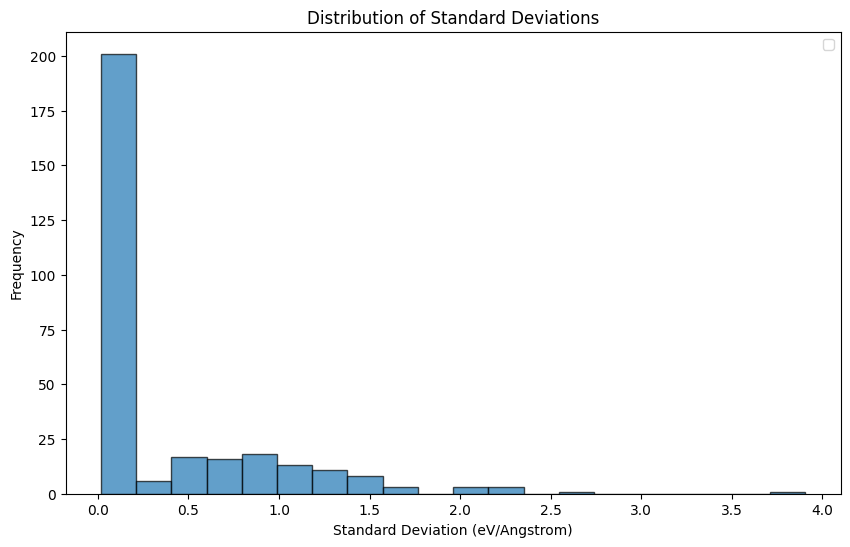

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(rmsd, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Standard Deviations')
plt.xlabel('Standard Deviation (eV/Angstrom)')
plt.ylabel('Frequency')
#plt.axvline(x=np.percentile(std_dev, 98), color='r', linestyle='--', label='98th Percentile')
plt.legend()

/tmp/ipykernel_1193372/2671433029.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


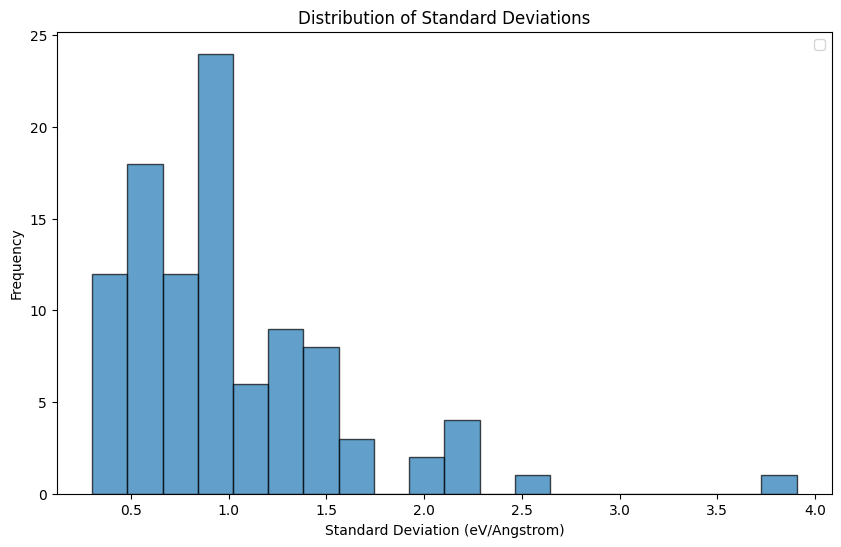

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(rmsd[201:], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Standard Deviations')
plt.xlabel('Standard Deviation (eV/Angstrom)')
plt.ylabel('Frequency')
#plt.axvline(x=np.percentile(std_dev, 98), color='r', linestyle='--', label='98th Percentile')
plt.legend()

In [19]:
filtered_structures,filtered_std_dev = al.filter_high_deviation_structures(all_configurations, rmsd,user_threshold=3.0,lower_threshold=.5)


2025-01-30 19:57:42,093 - INFO - User-defined upper threshold for filtering: 3.0
2025-01-30 19:57:42,094 - INFO - User-defined lower threshold for filtering: 0.5
2025-01-30 19:57:42,094 - INFO - Number of structures within threshold range: 85


/tmp/ipykernel_1193372/2313719436.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


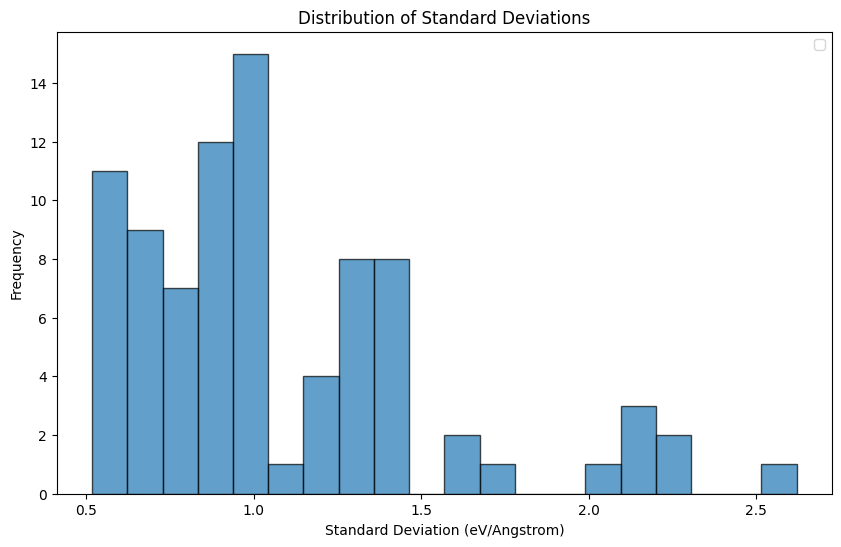

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_std_dev, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Standard Deviations')
plt.xlabel('Standard Deviation (eV/Angstrom)')
plt.ylabel('Frequency')
#plt.axvline(x=np.percentile(std_dev, 98), color='r', linestyle='--', label='98th Percentile')
plt.legend()